In [1]:
import pandas as pd
import numpy as np
import os
import sys

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
SCRIPT_DIR = (os.path.dirname(os.path.realpath("__file__")))
DATA_DIR = os.path.join(os.path.dirname(SCRIPT_DIR), "data")

In [3]:
train = pd.read_csv(f"{DATA_DIR}/train_E1GspfA.csv")
test = pd.read_csv(f"{DATA_DIR}/test_6QvDdzb.csv")

print(train.shape, test.shape)

(18247, 3) (7650, 2)


In [4]:
train.sample()

,date,hour,demand
1429,2018-11-09,22,259


In [5]:
test.sample()

,date,hour
6261,2022-01-22,2


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18247 entries, 0 to 18246
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    18247 non-null  object
 1   hour    18247 non-null  int64 
 2   demand  18247 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 427.8+ KB


In [7]:
train['datetime'] = pd.to_datetime(train['date'] + " " + train['hour'].astype(str) + ":00:00", errors="coerce")
test['datetime'] = pd.to_datetime(test['date'] + " " + test['hour'].astype(str) + ":00:00", errors="coerce")

train = train[['datetime', 'demand']]
test = test[['datetime']]

In [8]:
train.sample()

,datetime,demand
13008,2020-05-28 21:00:00,72


In [9]:
test.sample()

,datetime
551,2021-03-25 17:00:00


In [10]:
tmp = train.copy()
tmp['date'] = tmp['datetime'].dt.date
tmp = pd.pivot_table(
    tmp,
    index=['date'],
    values=['demand'],
    aggfunc=np.sum
)

In [11]:
# plt.figure(figsize=(20,10))
# sns.lineplot(data=train, x='datetime', y='demand')

In [12]:
import dtale

dtale.show(train)

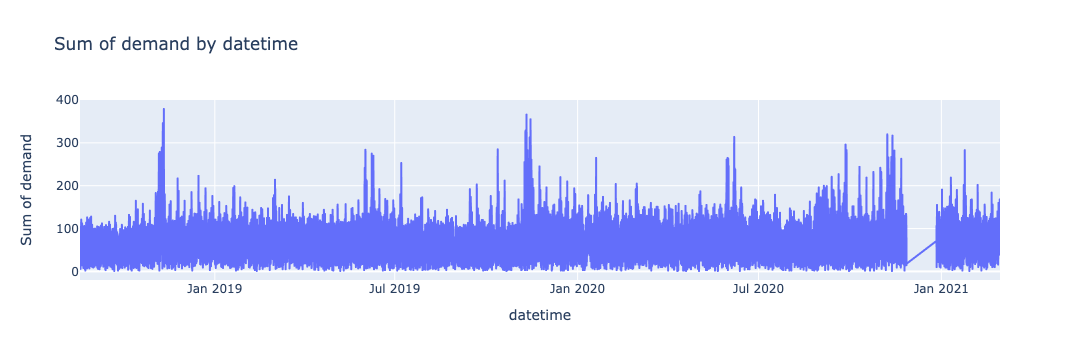

In [13]:
# DISCLAIMER: 'train' refers to the data you passed in when calling 'dtale.show'

import pandas as pd

if isinstance(train, (pd.DatetimeIndex, pd.MultiIndex)):
	train = train.to_frame(index=False)

# remove any pre-existing indices for ease of use in the D-Tale code, but this is not required
train = train.reset_index().drop('index', axis=1, errors='ignore')
train.columns = [str(c) for c in train.columns]  # update columns to strings in case they are numbers

chart_data = pd.concat([
	train['datetime'],
	train['demand'],
], axis=1)
chart_data = chart_data.sort_values(['datetime'])
chart_data = chart_data.rename(columns={'datetime': 'x'})
chart_data_sum = chart_data.groupby(['x'])[['demand']].sum()
chart_data_sum.columns = ['demand|sum']
chart_data = chart_data_sum.reset_index()
chart_data = chart_data.dropna()

import plotly.graph_objs as go

charts = []
line_cfg = {'line': {'shape': 'linear'}, 'mode': 'lines'}
charts.append(go.Scattergl(
	x=chart_data['x'], y=chart_data['demand|sum'], name='demand|sum', **line_cfg
))
figure = go.Figure(data=charts, layout=go.Layout({
    'legend': {'orientation': 'h'},
    'title': {'text': 'Sum of demand by datetime'},
    'xaxis': {'title': {'text': 'datetime'}},
    'yaxis': {'tickformat': '0:g', 'title': {'text': 'Sum of demand'}, 'type': 'linear'}
}))

# If you're having trouble viewing your chart in your notebook try passing your 'chart' into this snippet:
#
from plotly.offline import iplot, init_notebook_mode

init_notebook_mode(connected=True)
for chart in charts:
    chart.pop('id', None) # for some reason iplot does not like 'id'
iplot(figure)

In [14]:
train.loc[(train['datetime'] >= '2020-11-27') & (train['datetime'] <"2020-12-27")]

,datetime,demand


# CatBoost Regression

In [24]:

def datetime_disintegration(df, col):

    df[f"{col}_day"] = df[col].dt.day
    df[f"{col}_month"] = df[col].dt.month
    df[f"{col}_year"] = df[col].dt.year
    df[f"{col}_hour"] = df[col].dt.hour
    df[f"{col}_minute"] = df[col].dt.minute
    df[f"{col}_second"] = df[col].dt.second
    df[f"{col}_weekday"] = df[col].dt.weekday
    df[f"{col}_dayofyear"] = df[col].dt.dayofyear
    # df[f"{col}_dayofweek"] = df[col].dt.dayofweek
    df[f"{col}_day_name"] = df[col].dt.day_name()
    
    return df

train_catboost = datetime_disintegration(train, 'datetime')
test_catboost = datetime_disintegration(test, 'datetime')
train_catboost.sample()

,datetime,demand,datetime_day,datetime_month,datetime_year,datetime_hour,datetime_minute,datetime_second,datetime_weekday,datetime_dayofyear,datetime_day_name
13096,2020-06-01 23:00:00,32,1,6,2020,23,0,0,0,153,Monday


In [17]:
features = [
    'datetime_day', 'datetime_month', 'datetime_year',
    'datetime_hour', # 'datetime_minute', 'datetime_second',
    'datetime_weekday', 'datetime_dayofyear'
]

target = 'demand'

Xy = train_catboost.set_index('datetime')[features + [target]]
print(Xy.shape)

(18247, 7)


In [18]:
Xy.index

DatetimeIndex(['2018-08-18 09:00:00', '2018-08-18 10:00:00',
               '2018-08-18 13:00:00', '2018-08-18 14:00:00',
               '2018-08-18 15:00:00', '2018-08-18 16:00:00',
               '2018-08-18 17:00:00', '2018-08-18 18:00:00',
               '2018-08-18 19:00:00', '2018-08-18 20:00:00',
               ...
               '2021-02-28 14:00:00', '2021-02-28 15:00:00',
               '2021-02-28 16:00:00', '2021-02-28 17:00:00',
               '2021-02-28 18:00:00', '2021-02-28 19:00:00',
               '2021-02-28 20:00:00', '2021-02-28 21:00:00',
               '2021-02-28 22:00:00', '2021-02-28 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=18247, freq=None)

In [43]:
Xy_train = Xy.loc[:'2020-08-01']
Xy_val = Xy.loc['2020-08-01':'2020-12-27']
Xy_test = Xy.loc['2020-12-27':]

X_train = Xy_train[features]
y_train = Xy_train[target]
X_val = Xy_val[features]
y_val = Xy_val[target]
X_test = Xy_test[features]
y_test = Xy_test[target]

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(14375, 6) (14375,) (2496, 6) (2496,) (1419, 6) (1419,)


In [44]:
from catboost import CatBoostRegressor

cb_model = CatBoostRegressor(
    n_estimators=1000,
    max_depth=8,
    eval_metric="RMSE",
    use_best_model=True
)

cb_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    plot=True,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [45]:
feature_imp_df = pd.DataFrame.from_dict(dict(zip(cb_model.feature_names_, cb_model.feature_importances_)), orient='index', columns=['importance']).reset_index().rename(columns={'index': 'feature'}).sort_values('importance', ascending=False)
feature_imp_df


,feature,importance
5,datetime_dayofyear,31.158122
3,datetime_hour,30.598682
4,datetime_weekday,13.617505
1,datetime_month,9.463111
0,datetime_day,8.015546
2,datetime_year,7.147032


In [46]:
y_pred = cb_model.predict(X_test)

def get_regression_eval_metrics(y_test, y_pred):

    from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

    print("R^2 : ", r2_score(y_test, y_pred))
    print("MAE :", mean_absolute_error(y_test,y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

get_regression_eval_metrics(y_test, y_pred)

R^2 :  0.2605607482255736
MAE : 27.117987422351938
RMSE: 32.8549289652779


In [53]:
pred_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
dtale.show(pred_df)

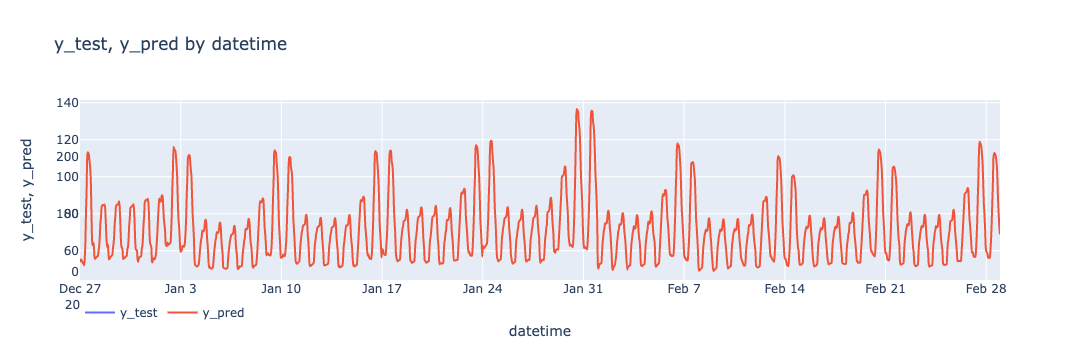

In [59]:
# # DISCLAIMER: 'pred_df' refers to the data you passed in when calling 'dtale.show'

# import pandas as pd

# if isinstance(pred_df, (pd.DatetimeIndex, pd.MultiIndex)):
# 	pred_df = pred_df.to_frame(index=False)

# # remove any pre-existing indices for ease of use in the D-Tale code, but this is not required
# pred_df = pred_df.reset_index().drop('index', axis=1, errors='ignore')
# pred_df.columns = [str(c) for c in pred_df.columns]  # update columns to strings in case they are numbers

# chart_data = pd.concat([
# 	pred_df['datetime'],
# 	pred_df['y_test'],
# 	pred_df['y_pred'],
# ], axis=1)
# chart_data = chart_data.sort_values(['datetime'])
# chart_data = chart_data.rename(columns={'datetime': 'x'})
# chart_data = chart_data.dropna()

# import plotly.graph_objs as go

# charts = []
# line_cfg = {'line': {'shape': 'spline', 'smoothing': 0.3}, 'mode': 'lines'}
# charts.append(go.Scatter(
# 	x=chart_data['x'], y=chart_data['y_test'], name='y_test', **line_cfg
# ))
# charts.append(go.Scatter(
# 	x=chart_data['x'], y=chart_data['y_pred'], name='y_pred', yaxis='y2', **line_cfg
# ))
# figure = go.Figure(data=charts, layout=go.Layout({
#     'legend': {'orientation': 'h'},
#     'title': {'text': 'y_test, y_pred by datetime'},
#     'xaxis': {'title': {'text': 'datetime'}},
#     'yaxis': {'tickformat': '0:g', 'title': {'text': 'y_test, y_pred'}, 'type': 'linear'}
# }))

# # If you're having trouble viewing your chart in your notebook try passing your 'chart' into this snippet:
# #
# from plotly.offline import iplot, init_notebook_mode

# init_notebook_mode(connected=True)
# for chart in charts:
#     chart.pop('id', None) # for some reason iplot does not like 'id'
# iplot(figure)

In [34]:
test_catboost['demand'] = pd.Series(np.round(cb_model.predict(test_catboost[features]),0), name='y_pred').astype(int)
test_catboost['date'] = test_catboost['datetime'].dt.date
test_catboost['hour'] = test_catboost['datetime'].dt.hour

submission = test_catboost[['date', 'hour', 'demand']]

# submission.to_csv(f'{DATA_DIR}/v1_catboost_32_27_0.26.csv', index=False)
# R^2 :  0.2605607482255736
# MAE : 27.117987422351938
# RMSE: 32.8549289652779

# PyCaret

In [61]:
import pycaret

ModuleNotFoundError: No module named 'pycaret'

# LSTM AutoEncoders

In [ ]:
# from keras.models import Sequential
# from keras.layers import LSTM, Dropout, Dense, Activation, Bidirectional, TimeDistributed, RepeatVector, Flatten
# from keras.layers.convolutional import Conv1D, MaxPooling1D

# def autoencoders_lstm_model(input_shape, n_steps_out=1):
#     # define model
#     """
#     input_shape: (n_steps_in, n_features)
#     """
#     model = Sequential()
#     model.add(LSTM(128, input_shape=input_shape)) # , activation='relu'
#     model.add(RepeatVector(n_steps_out))
#     model.add(LSTM(128, return_sequences=True)) # , activation='relu'
#     model.add(TimeDistributed(Dense(1)))
#     model.compile(optimizer='adam', loss='mse')
#     return model
